In [1]:
import cv2
import torch
from torch import nn
from d2l import torch as d2l
from torch.utils.data import DataLoader
import os

## Data Loading

In [2]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

In [2]:
class_dict = {'blues' : 0,
              'classical': 1,
              'country': 2,
              'disco' : 3,
              'hiphop' : 4,
              'jazz' : 5,
              'metal' : 6,
              'pop' : 7,
              'reggae': 8,
              'rock' : 9    
}

In [3]:
def collect_data():
    data = []
    # Collect all images from the 10 genres
    for genre in os.listdir("../Data/images_original"):
        for image in os.listdir("../Data/images_original/" + genre):
            image_path = "../Data/images_original/" + genre + "/" + image
            grayscale_img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            grayscale_img = grayscale_img[35:-36:, 54:-43]
            grayscale_img = torch.tensor(grayscale_img).to(dtype = torch.float32).clone().detach().requires_grad_(True)  #.requires_grad(True)
            #grayscale_img = torch.tensor(grayscale_img, requires_grad=True)
            # Splitting each image vertically into 5 different parts
            for i in range(5):
                # The data loader adds a dimension so I've removed a dimension from the image and class
                data.append((grayscale_img[ : ,  (67*i):67*(i+1)].reshape(1,217,67), torch.tensor(class_dict.get(genre)))) #.reshape(1)))
            
    return data         


In [4]:
data = collect_data()

In [5]:
len(data)

4995

In [12]:
data[500]   #[0].shape

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [16., 74., 66.,  ..., 32., 44., 25.],
          [16., 74., 66.,  ..., 32., 44., 25.],
          [ 6., 26., 20.,  ...,  3.,  0.,  0.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [13]:
train_size = int(0.8 * len(data))
test_size = len(data) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

train_dataset[2]

(tensor([[[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          ...,
          [ 0.,  8.,  0.,  ..., 62., 54., 30.],
          [ 0.,  8.,  0.,  ..., 62., 54., 30.],
          [31., 39., 26.,  ..., 33.,  0., 55.]]],
        grad_fn=<ReshapeAliasBackward0>),
 tensor(1))

In [14]:
# Get data in dataloader format
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

## First CNN

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net = nn.Sequential(

    nn.Conv2d(1, 32, kernel_size=3, padding = "same"), nn.Sigmoid(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding = "same"), nn.ReLU(),
 
    nn.AvgPool2d(kernel_size=2, stride=2),

    nn.Conv2d(64, 128, kernel_size=3, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(256, 512, kernel_size = 2, padding = "same"), nn.Sigmoid(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(512, 1024, kernel_size = 3, padding = "same"), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 3, padding = "same"), nn.Sigmoid(),
    
    nn.Flatten(),
    
    nn.Linear(30720, 5000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(5000, 4096), nn.Sigmoid(),
    
    nn.Linear(4096, 512), nn.Sigmoid(),
    
    nn.Linear(512, 64), nn.ReLU(),
    
    nn.Linear(64, 10), nn.Sigmoid(),
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

'''
Trainer
'''

trainer = torch.optim.Adam(net.parameters(), lr=lr)



# Sandbox net 
## Do whatever you want with this

In [ ]:
'''
Parameters
'''

epochs = 50
lr = 0.1
batch_size = 10

'''
Net

'''

net1 = nn.Sequential(

    nn.Conv2d(1, 16, kernel_size=2, padding = "same"), nn.Sigmoid(),
 
    nn.MaxPool2d(kernel_size=2, stride=2),

    nn.Conv2d(16, 32, kernel_size=2, padding = "same"), nn.Dropout(0.1), nn.Sigmoid(),

    nn.AvgPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 128, kernel_size = 2, padding = "same"), nn.Dropout(0.1), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size=2, stride = 2),
    
    nn.Conv2d(128, 256, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.MaxPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(256, 1024, kernel_size = 2, padding = "same"), nn.Dropout(0.2), nn.ReLU(),
    
    nn.AvgPool2d(kernel_size = 2, stride = 2),
    
    nn.Conv2d(1024, 2048, kernel_size = 2, padding = "same"), nn.ReLU(),
    
    nn.Flatten(),
    
    nn.Linear(122880, 20000), nn.Dropout(0.2), nn.ReLU(),
    
    nn.Linear(512, 128), nn.ReLU(),
    
    nn.Linear(128, 10), nn.ReLU()
      
)


'''
Loss
'''

loss = nn.CrossEntropyLoss(reduction='none')

#loss = nn.KLDivLoss(reduction='none')


'''
Trainer
'''

trainer = torch.optim.Adam(net1.parameters(), lr=lr)



In [36]:
path = "../Data/images_original/metal/metal00000.png"
obs = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
obs = obs[35:-36:, 54:-43]
obs = torch.from_numpy(obs)
obs = torch.reshape(obs, (1,1,217,335))
obs = obs.to(dtype = torch.float32)

### One Observation

# This doesn't work for `net1` but it still manages to train idk

In [37]:
'''
One observation
'''

for layer in net1:
    obs = layer(obs)
    print(layer.__class__.__name__,'output shape: \t',obs.shape)

Conv2d output shape: 	 torch.Size([1, 16, 217, 335])
Sigmoid output shape: 	 torch.Size([1, 16, 217, 335])
MaxPool2d output shape: 	 torch.Size([1, 16, 108, 167])
Conv2d output shape: 	 torch.Size([1, 32, 108, 167])
Dropout output shape: 	 torch.Size([1, 32, 108, 167])
Sigmoid output shape: 	 torch.Size([1, 32, 108, 167])
AvgPool2d output shape: 	 torch.Size([1, 32, 54, 83])
Conv2d output shape: 	 torch.Size([1, 128, 54, 83])
Dropout output shape: 	 torch.Size([1, 128, 54, 83])
ReLU output shape: 	 torch.Size([1, 128, 54, 83])
MaxPool2d output shape: 	 torch.Size([1, 128, 27, 41])
Conv2d output shape: 	 torch.Size([1, 256, 27, 41])
ReLU output shape: 	 torch.Size([1, 256, 27, 41])
MaxPool2d output shape: 	 torch.Size([1, 256, 13, 20])
Conv2d output shape: 	 torch.Size([1, 1024, 13, 20])
Dropout output shape: 	 torch.Size([1, 1024, 13, 20])
ReLU output shape: 	 torch.Size([1, 1024, 13, 20])
AvgPool2d output shape: 	 torch.Size([1, 1024, 6, 10])
Conv2d output shape: 	 torch.Size([1, 2048

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x122880 and 512x128)

### Loop

training on cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x24576 and 512x128)

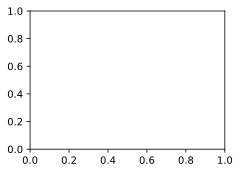

In [38]:
d2l.train_ch6(net1, train_loader, test_loader, epochs, lr, d2l.try_gpu())

In [82]:
net1.eval()

Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (1): Sigmoid()
  (2): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (4): Sigmoid()
  (5): AvgPool2d(kernel_size=5, stride=5, padding=0)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=512, out_features=128, bias=True)
  (8): ReLU()
  (9): Linear(in_features=128, out_features=10, bias=True)
  (10): ReLU()
)